## Setup

Includes:

- How to generate a placeholder dataset if you haven't already, just the basics to run "training" e2e on a tiny dataset
- How to download a dataset from OpenSLR

### Imports & paths

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import math
import wave
import struct
import os
import urllib.request
import tarfile
import numpy as np
import pickle
from matplotlib import pyplot as plt
from frechet_audio_distance import FrechetAudioDistance
from audiolm_pytorch import SoundStream, SoundStreamTrainer, HubertWithKmeans, SemanticTransformer, SemanticTransformerTrainer, HubertWithKmeans, CoarseTransformer, CoarseTransformerWrapper, CoarseTransformerTrainer, FineTransformer, FineTransformerWrapper, FineTransformerTrainer, AudioLM
from torch import nn
import torch
import torchaudio


# define all dataset paths, checkpoints, etc
dataset_folder = "/workspace/sanggeet/dataset_10s_wav"
vocal_folder = "/workspace/sanggeet/dataset_10s_wav/train/vocals"
instrumental_folder = "/workspace/sanggeet/dataset_10s_wav/train/accompaniments"
hubert_ckpt = 'checkpoints/hubert_base_ls960.pt'
hubert_quantizer = f'checkpoints/hubert_base_ls960_L9_km500.bin' # listed in row "HuBERT Base (~95M params)", column Quantizer

## Training

Now that we have a dataset, we can train AudioLM.

**Note**: do NOT type "y" to overwrite previous experiments/ checkpoints when running through the cells here unless you're ready to the entire results folder! Otherwise you will end up erasing things (e.g. you train SoundStream first, and if you choose "overwrite" then you lose the SoundStream checkpoint when you then train SemanticTransformer).

In [3]:
# !wget https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960.pt
# !wget https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960_L9_km500.bin

### CoarseTransformer - One Stage

In [3]:
wav2vec = HubertWithKmeans(
    checkpoint_path = f'./{hubert_ckpt}',
    kmeans_path = f'./{hubert_quantizer}',
    target_sample_hz=24000
)

# soundstream = SoundStream(
#     codebook_size = 1024,
#     rq_num_quantizers = 8,
# )
# soundstream.load(f"./{soundstream_ckpt}")
from audiolm_pytorch import EncodecWrapper
encodec = EncodecWrapper()

coarse_transformer = CoarseTransformer(
    num_semantic_tokens = wav2vec.codebook_size,
    codebook_size = 1024,
    num_coarse_quantizers = 3,
    dim = 512,
    depth = 6
)

In [ ]:
# trainer = CoarseTransformerTrainer(
#     transformer = coarse_transformer,
#     codec = encodec,
#     wav2vec = wav2vec,
#     # folder = dataset_folder,
#     folder_vocals = vocal_folder,
#     folder_instru = instrumental_folder,
#     batch_size = 4,
#     data_max_length = 24000 * 7,
#     save_results_every = 2000,
#     save_model_every = 2000,
#     num_train_steps = 40000
# )

# # trainer.load(f"results/coarse.transformer.8000.pt")

# logs_global = []
# def log_fn(logs):
#     logs_global.append(logs['loss'])

# trainer.train(log_fn = log_fn)

# import pickle
# pickle.dump(logs_global, open("logs_global.pkl", "wb"))

In [16]:
# test_logs = pickle.load(open("logs_global.pkl", "rb"))

## Reconstruction to test Coarse Transformer

In [9]:
# from pathlib import Path

# test_folder = "/workspace/sanggeet/dataset_10s_wav/train/accompaniments"
# path = Path(test_folder)
# exts = ['flac', 'wav', 'mp3', 'webm']
# # [file for ext in exts for file in path.glob(f'**/*.{ext}')]
# # list(path.glob(f'**/*.wav'))

In [10]:
# from audiolm_pytorch.data import SoundDataset

# test_dataset = SoundDataset(test_folder, \
#                          max_length = 320*32,
#                          target_sample_hz = wav2vec.target_sample_hz, # need 2 waves resampled differently here
#                         seq_len_multiple_of = encodec.seq_len_multiple_of)

# first_ind = test_dataset[0]
# first_ind.shape

In [6]:
from audiolm_pytorch.data import SoundDataset2
from einops import rearrange
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os

def batch_unique_consecutive(t, pad_value = 0.):
    unique_arr = [torch.unique_consecutive(el) for el in t.unbind(dim = 0)]
    return pad_sequence(unique_arr, batch_first = True, padding_value = pad_value)


# reconstructed_instumental.shape
def save_audios(gen_instru=None, orig_vocal=None, orig_instru=None, file_end=""):
    if not os.path.exists("/workspace/sanggeet/out/"):
        os.mkdir("/workspace/sanggeet/out/")
    if gen_instru is not None:
        torchaudio.save(f"/workspace/sanggeet/out/generated_instrumental_{file_end}.wav", 
                        gen_instru.detach().cpu(), encodec.target_sample_hz,
                        encoding="PCM_S", bits_per_sample=16)
    if orig_vocal is not None:
        torchaudio.save(f"/workspace/sanggeet/out/original_vocals_{file_end}.wav", 
                        orig_vocal.detach().cpu(), wav2vec.target_sample_hz, 
                        encoding="PCM_S", bits_per_sample=16)
    if orig_instru is not None:
        torchaudio.save(f"/workspace/sanggeet/out/original_instrumental_{file_end}.wav", 
                        orig_instru.detach().cpu(), encodec.target_sample_hz, 
                        encoding="PCM_S", bits_per_sample=16)

    if (orig_vocal is not None) and (orig_instru is not None):
        torchaudio.save(f"/workspace/sanggeet/out/original_mixed_{file_end}.wav", 
                        orig_vocal.detach().cpu() + orig_instru.detach().cpu(), 
                        encodec.target_sample_hz,
                        encoding="PCM_S", bits_per_sample=16)
    if (orig_vocal is not None) and (gen_instru is not None):
        torchaudio.save(f"/workspace/sanggeet/out/generated_mixed_{file_end}.wav", 
                        orig_vocal.detach().cpu()[0, :gen_instru.shape[1]] + gen_instru.detach().cpu(), 
                        encodec.target_sample_hz, 
                        encoding="PCM_S", bits_per_sample=16)


# Load trainer
trainer = CoarseTransformerTrainer(
    transformer = coarse_transformer,
    codec = encodec,
    wav2vec = wav2vec,
    # folder = dataset_folder,
    folder_vocals = vocal_folder,
    folder_instru = instrumental_folder,
    batch_size = 1,
    data_max_length = 24000 * 10,
    save_results_every = 1000,
    save_model_every = 1000,
    num_train_steps = 10000
)
print("Skipping training, loading trainer checkpoint")
trainer.load(f"results_onestage/coarse.transformer.38000.pt")


# test_folder = "/workspace/sanggeet/dataset_10s_wav/train/vocals"
# test_dataset = SoundDataset(test_folder, \
#                          max_length = 24000 * 10,
#                          target_sample_hz = wav2vec.target_sample_hz, # need 2 waves resampled differently here
#                         seq_len_multiple_of = encodec.seq_len_multiple_of)
folder_vocals = "/workspace/sanggeet/dataset_10s_wav/train/vocals"
folder_instru = "/workspace/sanggeet/dataset_10s_wav/train/accompaniments"
test_dataset = SoundDataset2(
                folder_vocals,
                folder_instru,
                max_length = 24000 * 10,
                target_sample_hz = (
                    wav2vec.target_sample_hz,
                    encodec.target_sample_hz
                ), # need 2 waves resampled differently here
                seq_len_multiple_of = encodec.seq_len_multiple_of
            )

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_loader = iter(test_loader)
for _ in tqdm(range(1), desc="Iterating to reach required batch"):
    test_datapt = next(test_loader)

reconstructed_instumentals = []
for i in tqdm(range(64), desc="Generating instrumentals"):
    semantic_token_ids = wav2vec(test_datapt[0][i].unsqueeze(0).cuda(), flatten = False)
    semantic_token_ids = rearrange(semantic_token_ids, 'b ... -> b (...)')
    semantic_token_ids = batch_unique_consecutive(semantic_token_ids, pad_value = -1)
    self_attn_mask = (semantic_token_ids != -1) & (semantic_token_ids != coarse_transformer.semantic_eos_id)
    semantic_token_ids = semantic_token_ids.masked_fill(~self_attn_mask, 0)

    reconstructed_instumentals.append(trainer.generate(semantic_token_ids=semantic_token_ids, reconstruct_wave = True))
    save_audios(gen_instru=reconstructed_instumentals[i], 
                orig_vocal=test_datapt[0][i].unsqueeze(0), 
                orig_instru=test_datapt[1][i].unsqueeze(0), 
                file_end=str(i))


training with dataset of 5219 samples and validating with randomly splitted 275 samples
Skipping training, loading trainer checkpoint


Iterating to reach required batch:   0%|          | 0/1 [00:00<?, ?it/s]

Generating instrumentals:   0%|          | 0/64 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

Computing label assignment and total inertia


generating coarse:   0%|          | 0/512 [00:00<?, ?it/s]

In [4]:
def smooth(scalars, weight: float):  # Weight between 0 and 1, scalars is a list
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [9]:
def plotLossValues(log_filepath, smoothing=0.6):
    losses = pickle.load(open("logs_global.pkl", "rb"))
    iterations = np.arange(len(losses))+1
    plt.plot(iterations, smooth(losses, smoothing))
    plt.xlabel("Iterations")
    plt.ylabel("Loss values")
    plt.title("Plot of Loss values vs number of iterations")
    plt.savefig("Loss.png")
    plt.show()

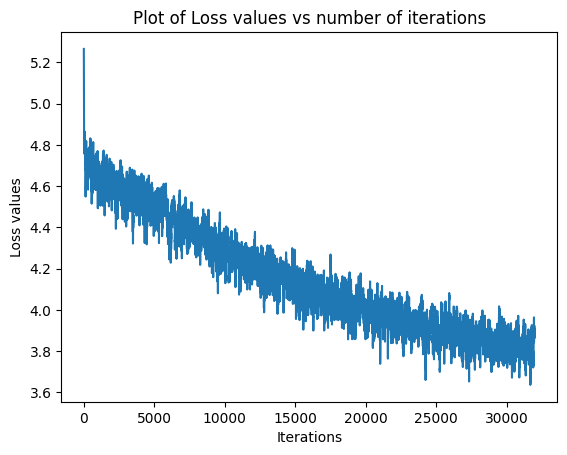

In [42]:
filepath = "logs_global.pkl"
plotLossValues(filepath, smoothing=0.95)

In [43]:
# to use `vggish`
frechet_vgg = FrechetAudioDistance(
    model_name="vggish",
    use_pca=False, 
    use_activation=False,
    verbose=False
)
frechet_vgg_pca = FrechetAudioDistance(
    model_name="vggish",
    use_pca=True, 
    use_activation=False,
    verbose=False
)
# to use `PANN`
frechet_pann = FrechetAudioDistance(
    model_name="pann",
    use_pca=False, 
    use_activation=False,
    verbose=False
)
frechet_pann_pca = FrechetAudioDistance(
    model_name="pann",
    use_pca=True, 
    use_activation=False,
    verbose=False
)

Using cache found in /root/.cache/torch/hub/harritaylor_torchvggish_master
Using cache found in /root/.cache/torch/hub/harritaylor_torchvggish_master
100%|██████████| 342M/342M [00:24<00:00, 14.6MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/torch/hub/Cnn14_16k_mAP%3D0.438.pth'

In [41]:
og_dir_path = "../../out/generated_mixed/"
generated_dir_path = "../../out/original_mixed/"

In [42]:
fad_score_vgg = frechet_vgg.score(og_dir_path, generated_dir_path)
fad_score_vgg_pca = frechet_vgg_pca.score(og_dir_path, generated_dir_path)

In [ ]:
fad_score_vgg, fad_score_vgg_pca

In [ ]:
fad_score_pann = frechet_pann.score("/path/to/background/set", "/path/to/eval/set")
fad_score_pann_pca = frechet_pann_pca.score("/path/to/background/set", "/path/to/eval/set")